# Idea for automatic detection of monotonicity

This note describes an idea for automatic detection of monotonocity in a probabilistic setting. 

We are interested in building Gaussian process models with monotonicity information. Let $f(x)$ be a function defined on the real-line and assume the variable $m \in \left\lbrace -1, 0, 1\right\rbrace$ dictates the monotonicity properties of $f$ such that

  $m = -1 \iff f$ is monotonic and decreasing
  
  $m = 0 \iff f$ is non-monotonic
  
  $m = 1 \iff f$ is monotonic and increasing
  
The idea is then to construct a joint model of $f$ and $m$ as follows

$\begin{align}p(\textbf{y}, \textbf{f}, \textbf{f}', m) = \frac{1}{Z} \mathcal{N}\left(\mathbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)p(\textbf{f}, \textbf{f}') \prod_{i=1}^M \phi\left(m\cdot f'_i\right)p(m)\end{align}$,

where $\textbf{y} \in \mathbf{R}^N$ is a set of observations, $\textbf{f} \in \mathbf{R}^N$ and $\textbf{f}' \in \mathbf{R}^M$ are the latent function and its derivatives, respectively, and $p(m)$ is the prior distribution on $m$.

The following code provides proof of concept of the idea by approximating the posterior distribution using EP.

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt

from scipy.stats import norm
from scipy.integrate import quad

import GPy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important;align=center; }</style>"))
np.set_printoptions(precision=4, linewidth=200)

import seaborn as snb
snb.set_style('darkgrid')
snb.set(font_scale = 1.5)

### Generate three data sets

First we generate three data sets, one for each value of $m \in \left\lbrace -1, 0, 1\right\rbrace$.

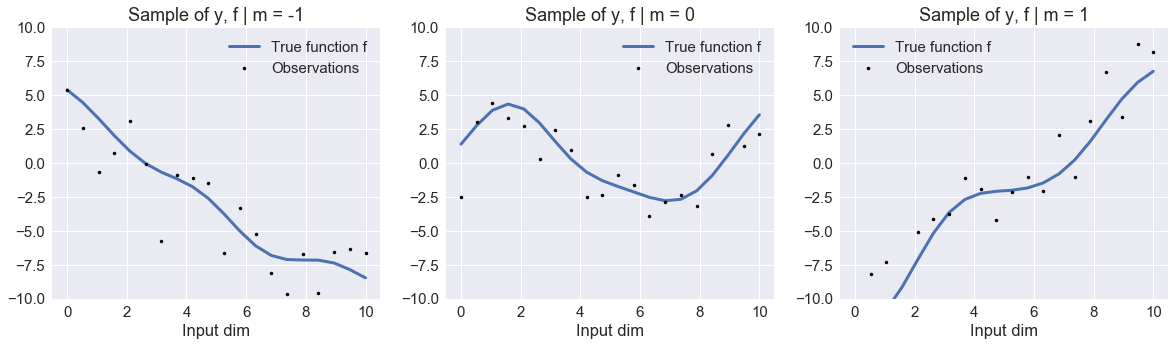

In [2]:
np.random.seed(100)
ms = [-1, 0, 1]

# number of observations
N, M = 20, 20

# kernel hyperparameters
k1, k2 = 5., 2.

# steepness of phi(nu*x) function
nu = 10.

# noise variance
sigma2 = 5.

# sample input dim for reg observations and gradient obs
t, t2 = np.linspace(0, 10, N)[:, None], np.linspace(0, 10, M)[:, None]

# generate kernel
def generate_joint_derivative_kernel(t, t2, k1, k2, jitter = 1e-8):

    assert(t.ndim == 2), "Wrong dimensions for t"
    assert(t2.ndim == 2), "Wrong dimensions for t"

    # kernel functions
    cov_fun, cov_fun1, cov_fun2 = lambda x, y: k1**2*np.exp(-0.5*(x-y)**2/k2**2), lambda x, y: -cov_fun(x,y)*(x-y)/k2**2, lambda x, y: cov_fun(x,y)*(1 - (x-y)**2/k2**2 )/k2**2

    # Prepare for joint kernel
    N, M = t.shape[0], t2.shape[0]
    K = np.zeros((N + M, N + M))

    # Kernel for regular observations and derivative observations
    K[:N, :N] = cov_fun(t, t.T)
    K[N:, N:] = cov_fun2(t2, t2.T)

    # Kernel for covariance between reg. and der. observations
    K[N:, :N] = cov_fun1(t2, t.T)
    K[:N, N:] = K[N:, :N].T

    # jitter
    K += jitter*np.identity(N + M)

    return K

K = generate_joint_derivative_kernel(t, t2, k1, k2)

# sample data sets
fs, zs,  ys = [], [], []
for m in ms:

    se = GPy.kern.RBF(input_dim = 1, lengthscale=k2, variance=k1**2)
    
    if np.abs(m) == 1:
        z = m*np.ones((M, 1))    
        se_der = GPy.kern.DiffKern(se, 0)
        gauss, probit = GPy.likelihoods.Gaussian(variance=sigma2), GPy.likelihoods.Binomial(gp_link = GPy.likelihoods.link_functions.Probit(nu=100, fixed=False))
        model = GPy.core.MultioutputGP(X_list=[np.zeros((0, 1)), t2], Y_list=[np.zeros((0, 1)), z], kernel_list=[se, se_der], likelihood_list = [gauss, probit], inference_method=GPy.inference.latent_function_inference.EP(ep_mode="nested"))
        mu, Sigma = model.predict(np.column_stack((t, np.zeros(N))), include_likelihood=False, full_cov=True)
    else:
        
        Sigma = se.K(t)
        mu = np.zeros((N, 1))
        
    L = np.linalg.cholesky(Sigma + 1e-8*np.identity(N))
    f = mu + np.dot(L, np.random.normal(0, 1, size = (len(mu), 1)))
    y = np.random.normal(f, np.sqrt(sigma2))
        
    
    fs.append(f)
    zs.append(z)
    ys.append(y)

# plot    
plt.figure(figsize = (20, 5))
for idx_plot, (f, y, m) in enumerate(zip(fs, ys, ms)):
    plt.subplot(1, 3 , 1 + idx_plot)
    plt.plot(t, f, label = 'True function f', linewidth = 3.)
    plt.plot(t, y, 'k.', label = 'Observations')
    plt.legend()
    plt.xlabel('Input dim');
    plt.title('Sample of y, f | m = %d' % m)
    plt.ylim((-10, 10))


### Auxilary functions

In [3]:
def plot_with_uncertainty(x, y, ystd=None, color='r', linestyle='-', fill=True, label=''):
    plt.plot(x, y, color=color, linestyle=linestyle, label=label)
    if not ystd is None:
        lower, upper = y - np.sqrt(ystd), y + np.sqrt(ystd)
        plt.plot(x, lower, color=color, alpha=0.5, linestyle=linestyle)
        plt.plot(x, upper, color=color, alpha=0.5, linestyle=linestyle)
        
        if fill:
            plt.fill_between(x.ravel(), lower, upper, color=color, alpha=0.25, linestyle=linestyle)

def update_posterior(K, eta_z, theta_z, eta_y, theta_y):
    D = K.shape[0]
    sqrt_theta = np.sqrt(theta_z + theta_y)
    G = sqrt_theta[:, None]*K
    B = np.identity(D) + G*sqrt_theta
    L = np.linalg.cholesky(B)
    V = np.linalg.solve(L, G)
    Sigma_full = K - np.dot(V.T, V)
    mu, Sigma = np.dot(Sigma_full, eta_z + eta_y), np.diag(Sigma_full)

    return mu, Sigma, Sigma_full, L

def map_to_probabilities(gamma):
    exp_gamma = np.exp(gamma)
    return exp_gamma/np.sum(exp_gamma)

def map_to_natural(p):
    return np.log(p)

def categorial_pmf(m, p):
    return (m == -1)*p[0] + (m==0)*p[1] + (m==1)*p[2]

npdf = lambda x, m, v: 1./np.sqrt(2*np.pi*v)*np.exp(-(x-m)**2/(2*v))
log_npdf = lambda x, m, v: -0.5*np.log(2*np.pi*v) -(x-m)**2/(2*v)
phi = lambda x: norm.cdf(x)
logphi = lambda x: norm.logcdf(x)

### EP approximation

In [4]:
def run_ep(y, t, t2, k1, k2, sigma2, max_itt=20, nu=10, alpha=0.9, tol=1e-4, verbose=1, pm=None):
    
    N, M = len(t), len(t2)
    D = N + M
    
    # prior on m
    if pm is None:
        pm = np.ones(3)/3.
    
    # prepare kernel
    K = generate_joint_derivative_kernel(t, t2, k1, k2)

    # prepare EP approximation
    eta_y, theta_y = np.zeros(D), np.zeros(D)
    eta_y[:N], theta_y[:N] = y[:, 0]/sigma2, 1./sigma2
    eta_z, theta_z = np.zeros(D), 1e-10*np.ones(D)
    gamma_z = np.zeros((M, 3))

    # prepare global approximation
    mu, Sigma, Sigma_full, L = update_posterior(K, eta_z, theta_z, eta_y, theta_y)
    gamma = np.sum(gamma_z, axis = 0) + map_to_natural(pm)

    for itt in range(max_itt):
    
        mu_old, Sigma_old = mu.copy(), Sigma.copy()

        for j in np.random.choice(range(M), size=M, replace=False):
            
            # compute offset for gradient indices
            i = N + j

            # compute cavity
            eta_cav, theta_cav, gamma_cav = mu[i]/Sigma[i] - eta_z[i], 1./Sigma[i] - theta_z[i], gamma - gamma_z[j]
            m_cav, v_cav = eta_cav/theta_cav, 1./theta_cav
            
            if v_cav <= 0:
                print('EP: Negative cavity observed at site %d in iteration %d, skipping update' % (j, itt + 1))
                continue
            
            # Compute moments
            ms = np.array([-1, 0, 1])
            means, variances = ms*nu*m_cav, (ms*nu)**2*v_cav
            z = means/np.sqrt(1 + variances)
            phiz = phi(z)
            pz = categorial_pmf(ms, map_to_probabilities(gamma_cav))
                        
            # Normalization            
            Z = np.sum( phiz*pz)
                        
            # First moment
            qs = phiz*m_cav + ms*nu*v_cav*npdf(z, 0, 1)/np.sqrt(1 + variances)
            site_m = np.sum(qs*pz)/Z
            
            # Second moment
            d, b = ms*nu*v_cav*npdf(z, 0, 1)/(phiz*np.sqrt(1 + variances)), (ms*nu)**2*v_cav**2*z*npdf(z, 0, 1)/(phiz*(1 + variances))
            q2s = phiz*(2*m_cav*(m_cav + d) + v_cav - m_cav**2 - b)
            site_m2 = np.sum(q2s*pz)/Z
            
            # variance
            site_v = site_m2 - site_m**2

            # moments for z
            gamma_mom = pz*phiz/Z
            
            new_eta = site_m/site_v - eta_cav
            new_theta = 1./site_v - theta_cav

            if new_theta < 0:

                new_theta = 1e-10
                new_variance = 1./(new_theta + theta_cav)
                new_eta = site_m/new_variance - eta_cav

            # update site
            eta_z[i], theta_z[i] = (1-alpha)*eta_z[i] + alpha*new_eta, (1-alpha)*theta_z[i] + alpha*new_theta
            gamma_z[j] = (1-alpha)*gamma_z[j] + alpha*(map_to_natural(gamma_mom) - gamma_cav)

            # update joint
            mu, Sigma, Sigma_full, L = update_posterior(K, eta_z, theta_z, eta_y, theta_y)
            gamma = np.sum(gamma_z, axis = 0) + map_to_natural(pm)
            

        # check convergence
        p = map_to_probabilities(gamma)
        
        if verbose > 1:
            print('Itt %d: p = (%3.2f, %3.2f, %3.2f)' % (itt, p[0], p[1], p[2]))

        diff_mu, diff_Sigma = np.mean((mu-mu_old)**2), np.mean((Sigma-Sigma_old)**2)
        if diff_mu < tol and diff_Sigma < tol:
            if verbose:
                print('Converged in %d iterations with diff_mu = %5.4e and diff_Sigma = %5.4e' % (itt + 1, diff_mu, diff_Sigma))
            break
            
    return mu, Sigma, p


ep_solutions = [run_ep(y, t, t2, k1, k2, sigma2, max_itt=100, nu=10, alpha=0.9) for m, y in zip(ms, ys)]

Converged in 4 iterations with diff_mu = 4.2419e-05 and diff_Sigma = 9.3701e-05
Converged in 4 iterations with diff_mu = 3.4854e-05 and diff_Sigma = 1.3179e-05
Converged in 4 iterations with diff_mu = 2.0129e-06 and diff_Sigma = 2.9834e-06


### Vanilla GP and monotonic GP sol

In [5]:
vanilla_solutions = []
for y in ys:
    # Vanilla
    se = GPy.kern.RBF(input_dim=1, lengthscale=k2, variance=k1**2)
    model = GPy.models.GPRegression(X=t, Y=y, kernel = se)
    vanilla_solutions.append(model.predict(Xnew=t, include_likelihood=False))

# monotonic
monotonic_solutions = []
for y, z in zip(ys, zs):
    se = GPy.kern.RBF(input_dim = 1, lengthscale=k2, variance=k1**2)
    se_der = GPy.kern.DiffKern(se, 0)

    gauss = GPy.likelihoods.Gaussian(variance=sigma2)
    probit = GPy.likelihoods.Binomial(gp_link = GPy.likelihoods.link_functions.Probit(nu=nu, fixed=True))
    model = GPy.core.MultioutputGP(X_list=[t, t2], Y_list=[y, z], kernel_list=[se, se_der], likelihood_list = [gauss, probit])

    X = np.zeros((len(t), 2))
    X[:, 0] = t.ravel()
    
    monotonic_solutions.append(model.predict(X, include_likelihood=False, full_cov=False))

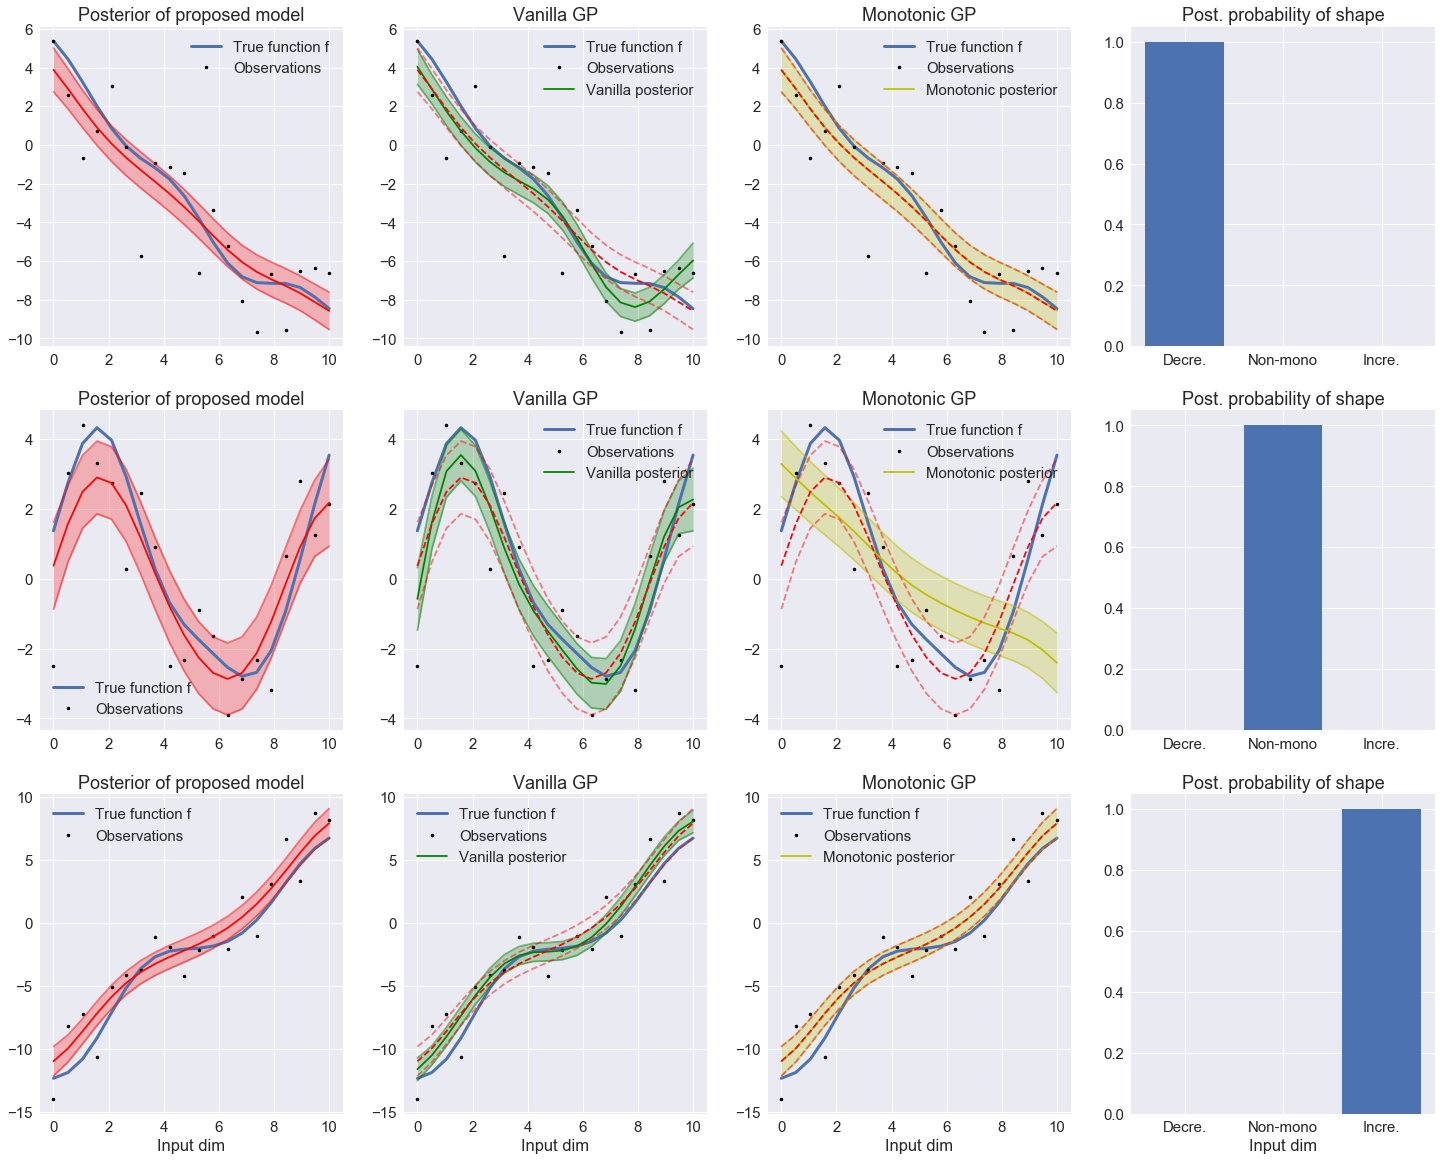

In [6]:
plt.figure(figsize = (25, 20))
for idx_plot, (f, y, ep_sol, vanilla_sol, monotoc_sol) in enumerate(zip(fs, ys, ep_solutions, vanilla_solutions, monotonic_solutions)):

    (mu, Sigma, p), (m_gpy, v_gpy), (mu_mon, sigma_mon)   = ep_sol, vanilla_sol, monotoc_sol
    
    plt.subplot(3, 4, 1 + idx_plot*4)
    plt.plot(t, f, label = 'True function f', linewidth = 3.)
    plt.plot(t, y, 'k.', label = 'Observations')
    plot_with_uncertainty(t, mu[:N], np.sqrt(Sigma[:N]), color = 'r')
    plt.legend()
    if idx_plot == 2:
        plt.xlabel('Input dim');
    plt.title('Posterior of proposed model')


    plt.subplot(3, 4, 2 + idx_plot*4)
    plt.plot(t, f, label = 'True function f', linewidth = 3.)
    plt.plot(t, y, 'k.', label = 'Observations')
    plot_with_uncertainty(t, m_gpy.ravel(), np.sqrt(v_gpy.ravel()), color = 'g', label='Vanilla posterior')
    plot_with_uncertainty(t, mu[:N], np.sqrt(Sigma[:N]), color = 'r', linestyle = '--', fill=False) 
    plt.title('Vanilla GP')
    plt.legend()
    if idx_plot == 2:
        plt.xlabel('Input dim');
    
    plt.subplot(3, 4, 3 + idx_plot*4)
    plt.plot(t, f, label = 'True function f', linewidth = 3.)
    plt.plot(t, y, 'k.', label = 'Observations')
    plot_with_uncertainty(t, mu_mon.ravel(), np.sqrt(sigma_mon.ravel()), color = 'y', label='Monotonic posterior')
    plot_with_uncertainty(t, mu[:N], np.sqrt(Sigma[:N]), color = 'r', linestyle = '--', fill=False) 
    plt.title('Monotonic GP')
    plt.legend()
    if idx_plot == 2:
        plt.xlabel('Input dim');

    plt.subplot(3, 4, 4 + idx_plot*4)
    ax = plt.subplot(3, 4, 4 + idx_plot*4)
    plt.bar([-1, 0, 1], p)
    ax.set_xticks([-1, 0, 1])
    ax.set_xticklabels(('Decre.', 'Non-mono', 'Incre.'))
    plt.title('Post. probability of shape')
    if idx_plot == 2:
        plt.xlabel('Input dim');




### Sweep slope of linear model

In [7]:
np.random.seed(1000)

num_rep = 20

slope_values = np.linspace(-1., 1., 20)
sols = np.zeros((num_rep, len(slope_values), 3))

N = 20
t = np.linspace(-5, 5., N)[:, None]
t2 = t.copy()
sigma2 = 1

for idx_rep in range(num_rep):
    
    print('Starting rep %d/%d...' % (idx_rep + 1, num_rep))

    for idx_slope, slope in enumerate(slope_values):
        y = slope*t + np.random.normal(0, np.sqrt(sigma2), size=(N, 1))
        sols[idx_rep, idx_slope, :] = run_ep(y, t, t2, k1, k2, sigma2, max_itt=20, nu=10, alpha=0.9, verbose=0)[2]
    

Starting rep 1/20...
Starting rep 2/20...
Starting rep 3/20...
Starting rep 4/20...
Starting rep 5/20...
Starting rep 6/20...
Starting rep 7/20...
Starting rep 8/20...
Starting rep 9/20...
Starting rep 10/20...
Starting rep 11/20...
Starting rep 12/20...
Starting rep 13/20...
Starting rep 14/20...
Starting rep 15/20...
Starting rep 16/20...
Starting rep 17/20...
Starting rep 18/20...
Starting rep 19/20...
Starting rep 20/20...


### Plot results

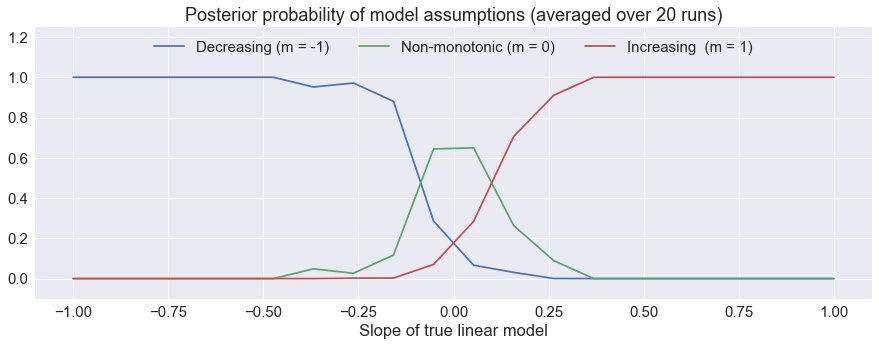

In [8]:
sols_mean = np.mean(sols, axis = 0)

label_dict = {-1: 'Decreasing (m = -1)', 0: 'Non-monotonic (m = 0)', 1: 'Increasing  (m = 1)'}

plt.figure(figsize = (15,5))
for (index, ppi), mi in zip(enumerate(sols_mean.T), [-1, 0, 1]):
    plt.plot(slope_values, ppi, label = label_dict[mi])
plt.legend(loc = 'upper center', ncol = 3)
plt.ylim((-0.1, 1.25))
plt.xlabel('Slope of true linear model')
plt.title('Posterior probability of model assumptions (averaged over %d runs)' % num_rep)